# EUCLIDEAN GEOMETRY – Euclidean Spaces  


## intro


The **Euclidean distance** is the classical metric to measure the *shortest path* between two points in an \(n\)-dimensional space (generalization of the Pythagorean theorem).  
In **data science** and **machine learning**, it is essential for:

- Measuring **similarity or dissimilarity** between examples.  
- Implementing algorithms such as **K-NN** and clustering methods (**K-means, DBSCAN**).  
- Building **distance matrices** and understanding the geometry of high-dimensional data.  

In this notebook, we apply Euclidean distance to **face recognition and comparison** using **embeddings** (feature vectors generated by a deep learning model), since it is the basis for methods like **similarity search**, **identity verification**, **face clustering**, and exploratory analysis.  

> Key idea: **the smaller the Euclidean distance between embeddings, the greater the similarity between faces**; the larger the distance, the lower the similarity.


## mathematical definition 



Given two points in  

$$
\mathbb{R}^n
$$

$$
x = (x_1, x_2, \dots, x_n), \qquad
y = (y_1, y_2, \dots, y_n)
$$

the **Euclidean distance** is defined as:

$$
d(x,y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2 }
$$

- In **2D**, it coincides with the **Pythagorean theorem**.  
- In **n dimensions**, it extends the same concept to any number of coordinates.  

**Example (2D):**

$$
x=(1,2), \quad y=(4,6) \;\Rightarrow\;
d(x,y) = \sqrt{(1-4)^2 + (2-6)^2} = \sqrt{9+16} = 5
$$

# practical application : faces and embeddings

1. Start with **images of people** (faces).  
2. A **deep learning model** (e.g., FaceNet) generates for each image an **embedding** $$v$$ in $${R}^d$$ space.  

3. Each embedding is normalized using the $$L_2$$  norm:  

$$
\tilde v = \frac{v}{\|v\|_2}
$$  

4. The Euclidean distance between embeddings measures the **similarity**:  

$$
d(\tilde v_a,\tilde v_b) = \sqrt{\sum_j (\tilde v_{a,j} - \tilde v_{b,j})^2 }
$$  

5. A **threshold** is applied to decide:  

- If \( d < threshold \) ⇒ **same face**  
- If \( d > threshold \) ⇒ **different faces**  

---

## code implementation

### dependencies and libraries: 

we use DeepFace as a facial recognition framework, and use SciPy and OpenCV-Python to perform computer vision processing.

In [2]:
import ipywidgets as widgets
from IPython.display import display, Image as IPyImage, clear_output
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist   
import io
import cv2
import numpy as np
from PIL import Image
import os
import requests
from deepface import DeepFace

In [3]:
# upload widget to replace files.upload from Colab
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)

def on_upload_change(change):
    # we list each file uploaded inside the notebook (inline) and save it to ./uploads/
    uploads_dir = os.path.join(os.getcwd(), 'uploads')
    os.makedirs(uploads_dir, exist_ok=True)
    clear_output(wait=True)
    display(upload)
    for name, file_info in upload.value.items():
        try:
            print(f'image upload: {name}')
            image_bytes = file_info['content']
            # save bytes on disk with the same filename
            save_path = os.path.join(uploads_dir, name)
            with open(save_path, 'wb') as f:
                f.write(image_bytes)
            print('saved in:', save_path)
            # use PIL to open image from bytes and display inline
            img = Image.open(io.BytesIO(image_bytes)).convert('RGB')
            display(img)
            # if we need process with OpenCV (BGR)
            img_array = np.array(img)[:,:,::-1].copy()  # RGB->BGR
           
            print('shape (H,W,C):', img_array.shape, 'dtype:', img_array.dtype)
        except Exception as e:
            print('error processing', name, '->', e)

upload.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload')

also , we can use AI to generate some images and save it on the environment

In [5]:
os.makedirs("faces_ai", exist_ok=True)

for i in range(4):
    img_data = requests.get("https://thispersondoesnotexist.com").content
    with open(f"faces_ai/person{i+1}.jpg", "wb") as f:
        f.write(img_data)
    print(f"Generated: person{i+1}.jpg")


Generated: person1.jpg
Generated: person2.jpg
Generated: person3.jpg
Generated: person4.jpg


### proceed visualizating the generated images

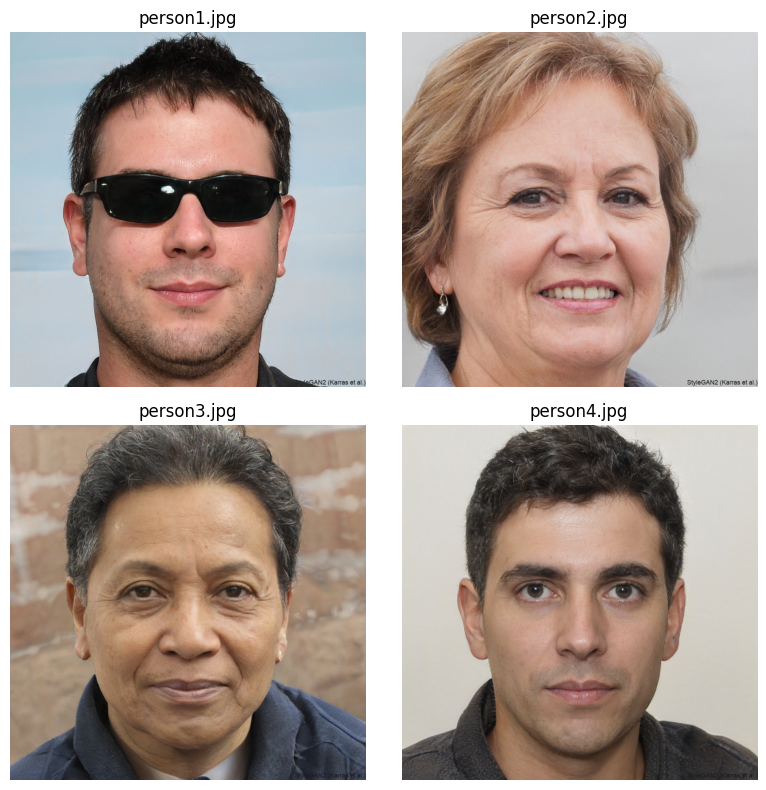

In [6]:
image_paths = [f"faces_ai/person{i+1}.jpg" for i in range(4)]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, path in zip(axes.flatten(), image_paths):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(os.path.basename(path))
    ax.axis("off")
plt.tight_layout()
plt.show()

from here we extract embedding for each face using the facenet512 deep face model

In [7]:
MODEL_NAME = "Facenet512"

embeddings = []   # will store one embedding per image

for path in image_paths:
    print(f"Processing: {path}")
    rep = DeepFace.represent(
        img_path=path,
        model_name=MODEL_NAME,
        detector_backend="retinaface",
        align=True,
        enforce_detection=True
    )
    # Take embedding vector and normalize (L2)
    v = np.array(rep[0]["embedding"], dtype=np.float32)
    v = v / (np.linalg.norm(v) + 1e-12)
    embeddings.append(v)
#Each v is a 512-dimensional normalized vector describing the face, and all are now stored in embeddings.
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)

Processing: faces_ai/person1.jpg
Processing: faces_ai/person2.jpg
Processing: faces_ai/person3.jpg
Processing: faces_ai/person4.jpg
Embeddings shape: (4, 512)
